In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\google\auth\crypt\_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Importer des données

In [2]:

data=pd.read_csv("../laboratory.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [6]:

data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

start_date = '2023-04-19'
end_date = '2023-06-03'
data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
# dates_to_remove = ['2023-04-17', '2023-05-21']
# dates_to_remove = pd.to_datetime(dates_to_remove)
# data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]
print(data)

       oxygen    pm10     co      co2       so2     no2           timestamp  \
18440  20.789   9.315  1.735  507.934  2216.850  21.831 2023-04-19 11:39:01   
18441  20.790   9.040  1.730  504.029  2216.820  21.776 2023-04-19 11:41:03   
18442  20.789  10.338  1.726  503.302  2216.730  22.191 2023-04-19 11:43:05   
18443  20.793   9.173  1.723  503.272  2216.770  23.159 2023-04-19 11:45:06   
18444  20.792   8.218  1.720  503.708  2216.800  24.173 2023-04-19 11:47:08   
...       ...     ...    ...      ...       ...     ...                 ...   
49903  20.925   1.258  1.500  462.672   130.865  31.681 2023-06-02 23:51:16   
49904  20.925   1.608  1.500  460.642   130.676  31.438 2023-06-02 23:53:17   
49905  20.925   1.231  1.500  462.282   130.358  31.555 2023-06-02 23:55:18   
49906  20.924   1.321  1.500  460.177   129.813  31.540 2023-06-02 23:57:19   
49907  20.924   1.341  1.500  460.992   129.270  31.233 2023-06-02 23:59:20   

         pm1  dewpt     tvoc      o3   sound  pm2_5

Modifier le nom de timestamp et le convertir en index

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen    pm10     co      co2      so2     no2    pm1  \
date                                                                          
2023-04-19 11:39:01  20.789   9.315  1.735  507.934  2216.85  21.831  6.452   
2023-04-19 11:41:03  20.790   9.040  1.730  504.029  2216.82  21.776  6.477   
2023-04-19 11:43:05  20.789  10.338  1.726  503.302  2216.73  22.191  6.661   
2023-04-19 11:45:06  20.793   9.173  1.723  503.272  2216.77  23.159  6.771   
2023-04-19 11:47:08  20.792   8.218  1.720  503.708  2216.80  24.173  5.844   

                     dewpt  tvoc      o3   sound  pm2_5  temperature  \
date                                                                   
2023-04-19 11:39:01  6.523   0.0  27.653  57.259  7.996       19.024   
2023-04-19 11:41:03  6.466   0.0  27.600  52.367  8.203       19.012   
2023-04-19 11:43:05  6.456   0.0  27.512  52.689  8.830       19.009   
2023-04-19 11:45:06  6.458   0.0  27.481  56.539  8.191       19.012   
2023-04-19 11:

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

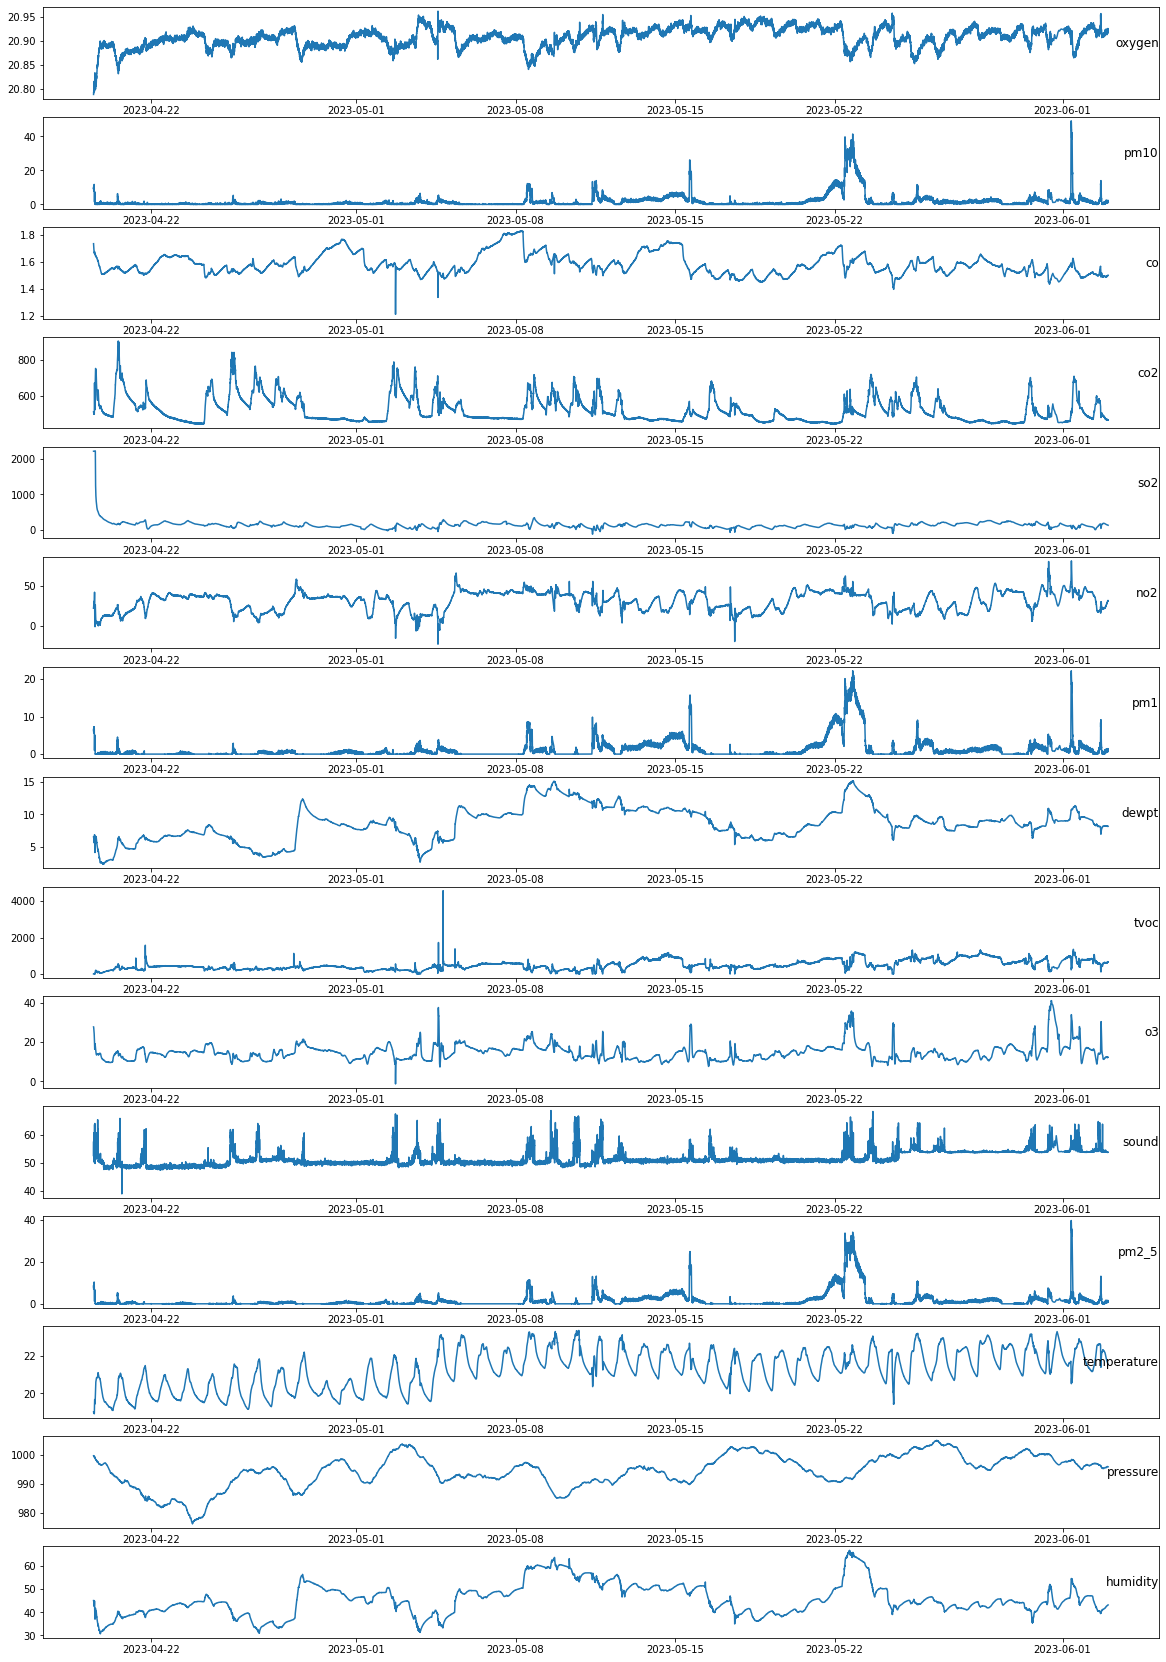

In [8]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

In [9]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [11]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,0.452520,0.206875
2,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,0.463491,0.222687
3,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,0.594671,0.206572
4,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,0.628608,0.173711
5,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,0.503492,0.206244


In [12]:
n_seconds = 720
n_features = 15

reframed = series_to_supervised(scaled, n_seconds, 1)

In [13]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-720),var2(t-720),var3(t-720),var4(t-720),var5(t-720),var6(t-720),var7(t-720),var8(t-720),var9(t-720),var10(t-720),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
720,0.000000,0.189904,0.848387,0.149366,0.996458,0.431124,0.290591,0.325957,0.0,0.684472,...,0.574194,0.630011,0.114913,0.429063,0.015043,0.185340,0.077491,0.378539,0.317217,0.012206
721,0.005791,0.184298,0.840322,0.141075,0.996445,0.430600,0.291717,0.321531,0.0,0.683219,...,0.574194,0.630300,0.114844,0.433605,0.009188,0.186660,0.076930,0.378350,0.337695,0.005548
722,0.000000,0.210760,0.833871,0.139532,0.996406,0.434559,0.300005,0.320755,0.0,0.681139,...,0.572581,0.636081,0.114712,0.433739,0.001937,0.186893,0.080960,0.377783,0.364544,0.001337
723,0.023125,0.187009,0.829032,0.139468,0.996424,0.443796,0.304959,0.320910,0.0,0.680407,...,0.572581,0.632039,0.114831,0.433443,0.014277,0.190077,0.080595,0.376956,0.337729,0.011324
724,0.017342,0.167540,0.824193,0.140394,0.996436,0.453471,0.263208,0.319124,0.0,0.677807,...,0.574194,0.636372,0.114893,0.434350,0.006801,0.190931,0.081916,0.376672,0.323452,0.008953
725,0.052032,0.179446,0.817742,0.136453,0.996360,0.460178,0.288835,0.316950,0.0,0.675136,...,0.574194,0.638103,0.115003,0.434636,0.011395,0.191707,0.080861,0.376530,0.312856,0.007944
726,0.052032,0.165583,0.809677,0.129000,0.996343,0.468756,0.288925,0.314232,0.0,0.670976,...,0.572581,0.645916,0.115204,0.434798,0.020853,0.193804,0.080686,0.376790,0.341579,0.011853
727,0.063583,0.197468,0.801613,0.128302,0.996262,0.474767,0.309373,0.309341,0.0,0.665280,...,0.572581,0.641245,0.115288,0.432498,0.018511,0.194037,0.080763,0.376838,0.341102,0.012534
728,0.057808,0.198426,0.795161,0.133763,0.996079,0.475073,0.326217,0.304760,0.0,0.660529,...,0.572581,0.649649,0.115476,0.432117,0.021619,0.196211,0.081027,0.375892,0.329688,0.015233
729,0.098267,0.184787,0.791935,0.125911,0.996032,0.475311,0.317209,0.303440,0.0,0.658497,...,0.572581,0.651906,0.115716,0.430466,0.017115,0.197609,0.080922,0.375680,0.332413,0.012685


In [14]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows * 0.9)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(28321, 10800) (28321, 12) (2427, 10800) (2427, 12)


In [15]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(2427, 720, 15) (28321, 720, 15)


In [16]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

# test3
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.5))
# model.add(LSTM(50))
# model.add(Dropout(0.5))
# model.add(Dense(11))
# model.compile(loss='mae', optimizer='adam')
# print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                13200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                612       
Total params: 13,812
Trainable params: 13,812
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(train_X, train_y, epochs=300, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Epoch 1/300
197/197 - 152s - loss: 0.1049 - val_loss: 0.0627
Epoch 2/300
197/197 - 161s - loss: 0.0714 - val_loss: 0.0540
Epoch 3/300
197/197 - 165s - loss: 0.0586 - val_loss: 0.0453
Epoch 4/300
197/197 - 167s - loss: 0.0501 - val_loss: 0.0371
Epoch 5/300
197/197 - 167s - loss: 0.0440 - val_loss: 0.0370
Epoch 6/300


In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

          0      1      2           3           4          5      6      7   \
0  20.919001  2.035  1.570  445.571014  197.987000  52.342999  1.433  8.938   
1  20.919001  1.995  1.569  444.832001  196.900986  52.308998  1.706  8.936   
2  20.919001  2.609  1.570  444.222992  196.459000  52.328003  2.481  8.949   
3  20.919001  2.462  1.570  443.811005  197.253998  52.031002  2.064  8.961   
4  20.920000  1.877  1.570  444.075989  196.863007  51.806999  1.677  8.963   

           8          9          10     11  
0  933.833984  17.576000  53.719002  1.876  
1  930.737000  17.565998  54.139000  1.980  
2  928.432983  17.568001  53.848000  2.607  
3  929.002991  17.548998  53.737000  2.462  
4  931.614014  17.556997  53.770000  1.787  


In [ ]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


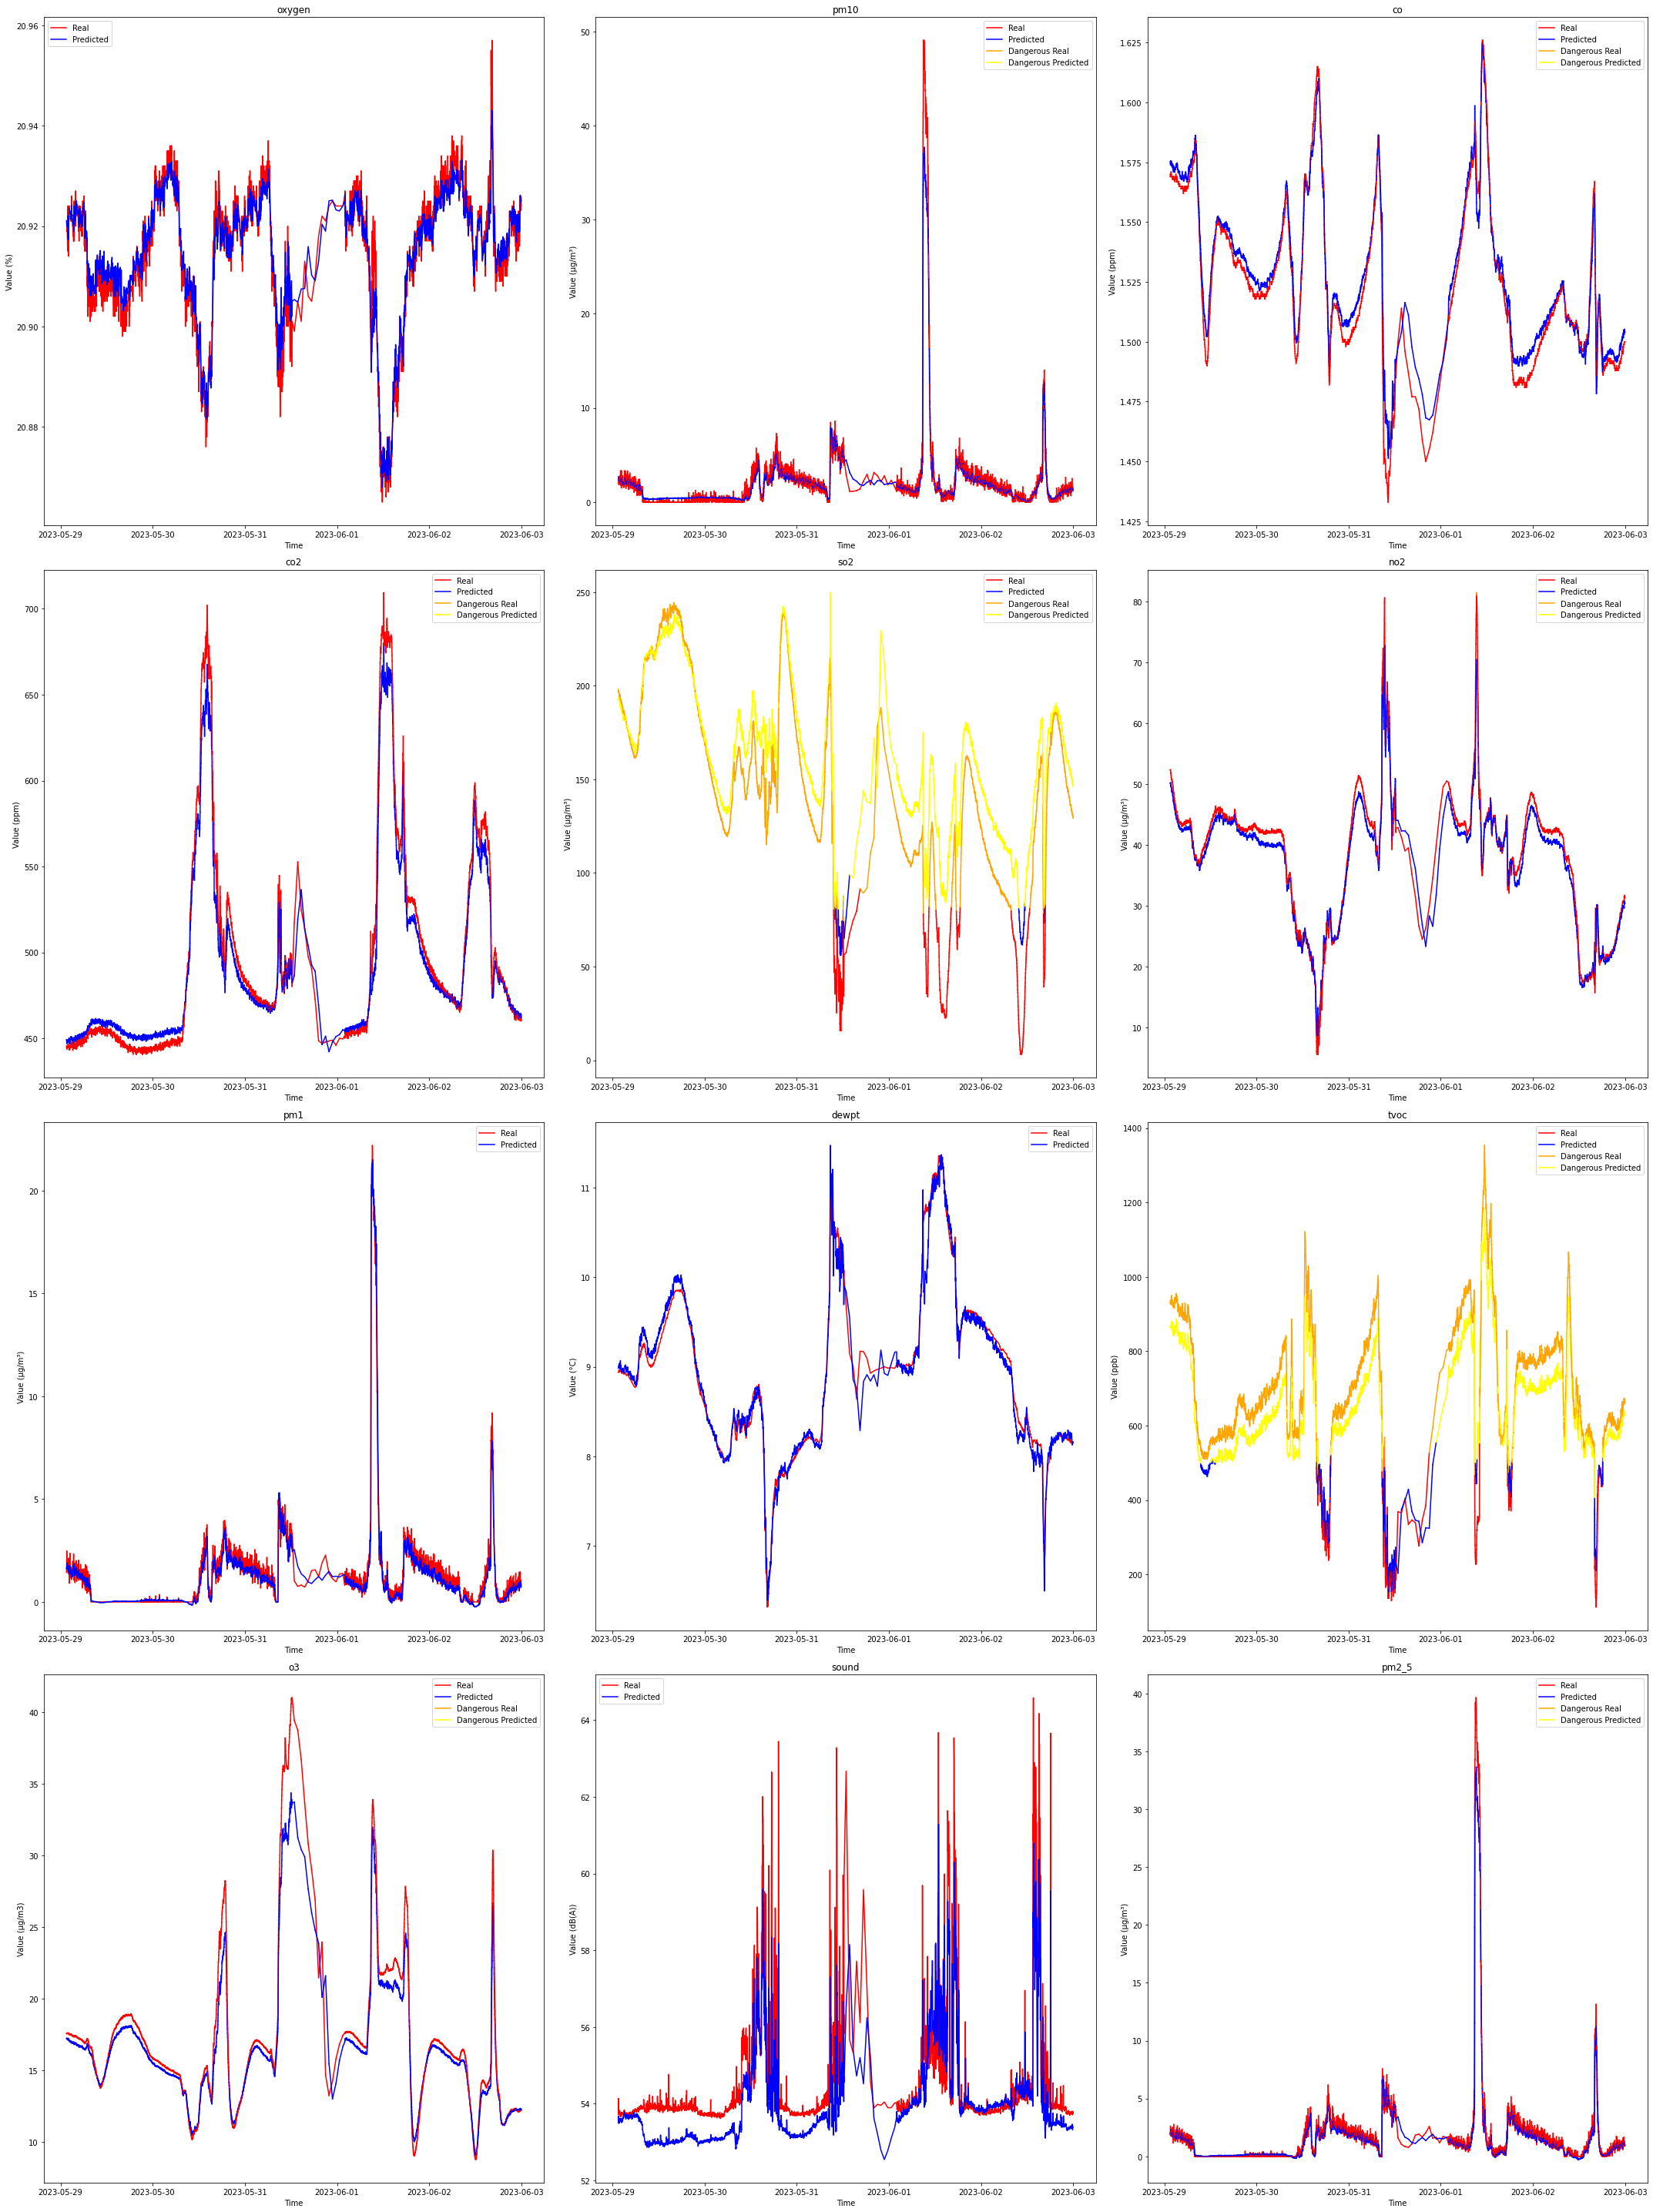

In [ ]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

In [ ]:
selected_columns2 = [i for i in range(n_features) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(3140, 12) (3140, 12)
Test RMSE for oxygen: 0.004
Test RMSE for pm10: 1.323
Test RMSE for co: 0.006
Test RMSE for co2: 11.171
Test RMSE for so2: 25.662
Test RMSE for no2: 1.769
Test RMSE for pm1: 0.465
Test RMSE for dewpt: 0.131
Test RMSE for tvoc: 74.121
Test RMSE for o3: 1.322
Test RMSE for sound: 1.012
Test RMSE for pm2_5: 0.880


In [ ]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [ ]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [ ]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [ ]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [ ]:
## NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in inv_yhat_NO2_values]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in inv_y_NO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [ ]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in inv_yhat_CO_values]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in inv_y_CO_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [ ]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.921070  2.397770  1.575348  449.237000  193.655075  50.117260  1.664308   
1  20.920401  2.297894  1.574576  448.800934  193.602203  50.162968  1.588212   
2  20.920086  2.319016  1.574016  448.168671  192.739151  50.132389  1.596914   
3  20.919933  2.660267  1.575577  446.974945  192.466522  50.204605  1.852366   
4  20.919943  2.702729  1.575567  446.970306  193.472885  49.881847  1.891207   

       col7        col8       col9  ...     col11     col12     col13  \
0  8.984503  863.460754  17.207222  ...  2.015471  3.359119  2.397770   
1  9.000072  866.013916  17.205580  ...  1.920804  3.201340  2.297894   
2  8.994915  866.316711  17.213079  ...  1.934790  3.224651  2.319016   
3  9.009136  867.302795  17.234081  ...  2.256276  3.760459  2.660267   
4  9.025195  865.819763  17.204226  ...  2.300588  3.834314  2.702729   

        col14      col15      col16      col17  AQI_calculated  Checks  \


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.7929936305732485


In [ ]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

2490
